<a href="https://colab.research.google.com/github/manurah/ML-CW/blob/main/ML_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Task 01**



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Create a directory to save plots for your report
OUTPUT_DIR = "eda_plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Plots will be saved to: {OUTPUT_DIR}")

Plots will be saved to: eda_plots


### 1. Load Dataset (Local File)
Make sure the filename below matches the file you uploaded.

In [4]:
# Define the filename (Change this if your file has a different name)
filename = '/content/drive/MyDrive/cw/WA_Fn-UseC_-Telco-Customer-Churn.csv'
# Fallback name often used
filename_alt = 'Telco-Customer-Churn.csv'

if os.path.exists(filename):
    file_path = filename
elif os.path.exists(filename_alt):
    file_path = filename_alt
else:
    file_path = None
    print("ERROR: CSV file not found! Please upload your dataset to the Colab Files tab on the left.")

if file_path:
    df = pd.read_csv(file_path)
    print(f"Dataset loaded successfully from {file_path}")
    print(f"Shape: {df.shape}")
    display(df.head())

Dataset loaded successfully from /content/drive/MyDrive/cw/WA_Fn-UseC_-Telco-Customer-Churn.csv
Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 2. Data Cleaning & Preprocessing
We need to fix `TotalCharges` (convert to numeric) and handle `SeniorCitizen` encoding.

In [5]:
if file_path:
    # 1. 'TotalCharges' is often read as object because of empty strings " " for new customers.
    # We force it to numeric, converting errors to NaN
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # 2. Fill missing TotalCharges with 0 (these are usually new customers with 0 tenure)
    null_count = df['TotalCharges'].isnull().sum()
    print(f"Found {null_count} missing values in TotalCharges. Filling with 0.")
    df['TotalCharges'] = df['TotalCharges'].fillna(0)

    # 3. SeniorCitizen is 0/1, map to Yes/No for better graphs
    df['SeniorCitizen'] = df['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

    # 4. Drop customerID as it is not useful for analysis
    if 'customerID' in df.columns:
        df = df.drop('customerID', axis=1)

    print("Data Cleaning Complete.")

Found 11 missing values in TotalCharges. Filling with 0.
Data Cleaning Complete.


### 3. Target Distribution (Churn)

/tmp/ipython-input-1403040351.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Churn', data=df, palette='viridis')


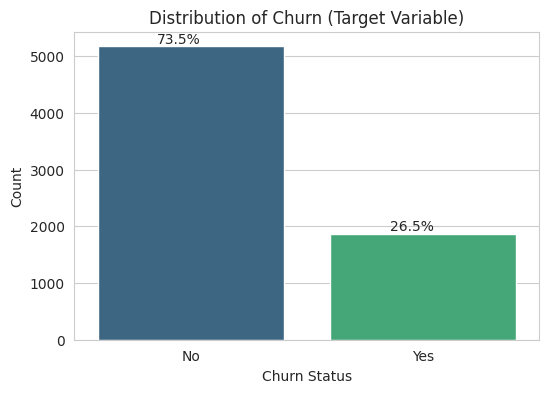

In [6]:
if file_path:
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x='Churn', data=df, palette='viridis')
    plt.title('Distribution of Churn (Target Variable)')
    plt.xlabel('Churn Status')
    plt.ylabel('Count')

    # Add percentages
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            percentage = '{:.1f}%'.format(100 * height/total)
            x = p.get_x() + p.get_width() / 2 - 0.05
            y = height
            ax.annotate(percentage, (x, y), ha='center', va='bottom')

    plt.savefig(f"{OUTPUT_DIR}/1_churn_distribution.png")
    plt.show()

### 4. Numerical Features Analysis
Checking Tenure, Monthly Charges, and Total Charges.

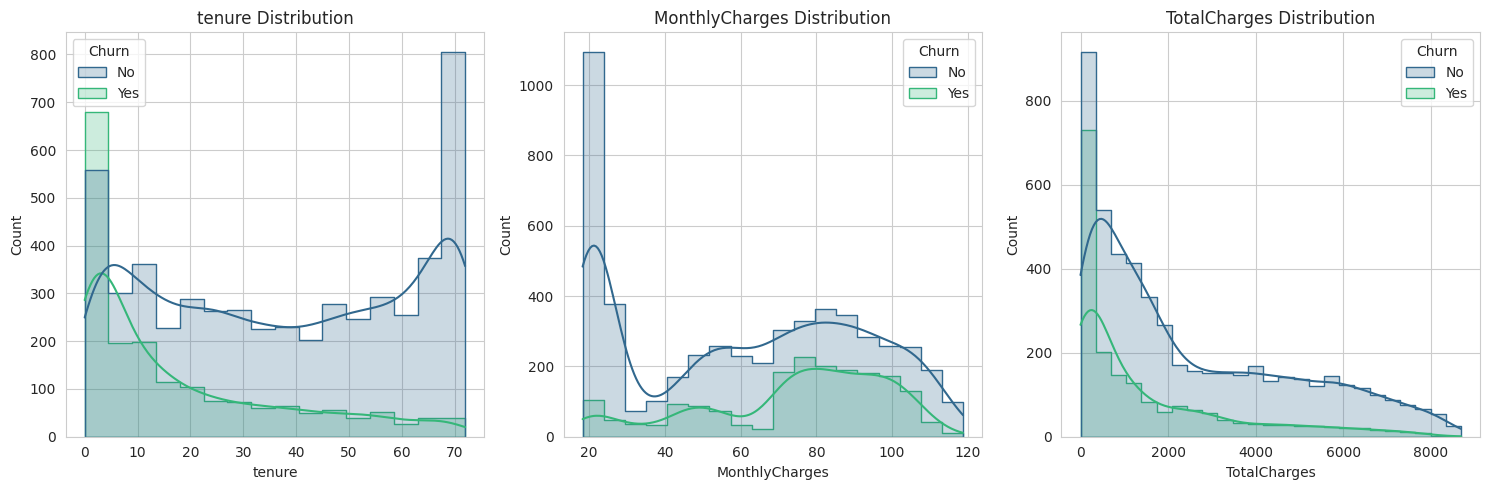

In [7]:
if file_path:
    num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

    plt.figure(figsize=(15, 5))
    for i, col in enumerate(num_cols):
        plt.subplot(1, 3, i+1)
        sns.histplot(data=df, x=col, hue='Churn', kde=True, element="step", palette='viridis')
        plt.title(f'{col} Distribution')

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/2_numerical_distributions.png")
    plt.show()

### 4.5. Outlier Detection (Boxplots)
Identifying extreme values in numerical data is crucial for understanding data quality.

/tmp/ipython-input-1369182147.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette='viridis')
/tmp/ipython-input-1369182147.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette='viridis')
/tmp/ipython-input-1369182147.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette='viridis')


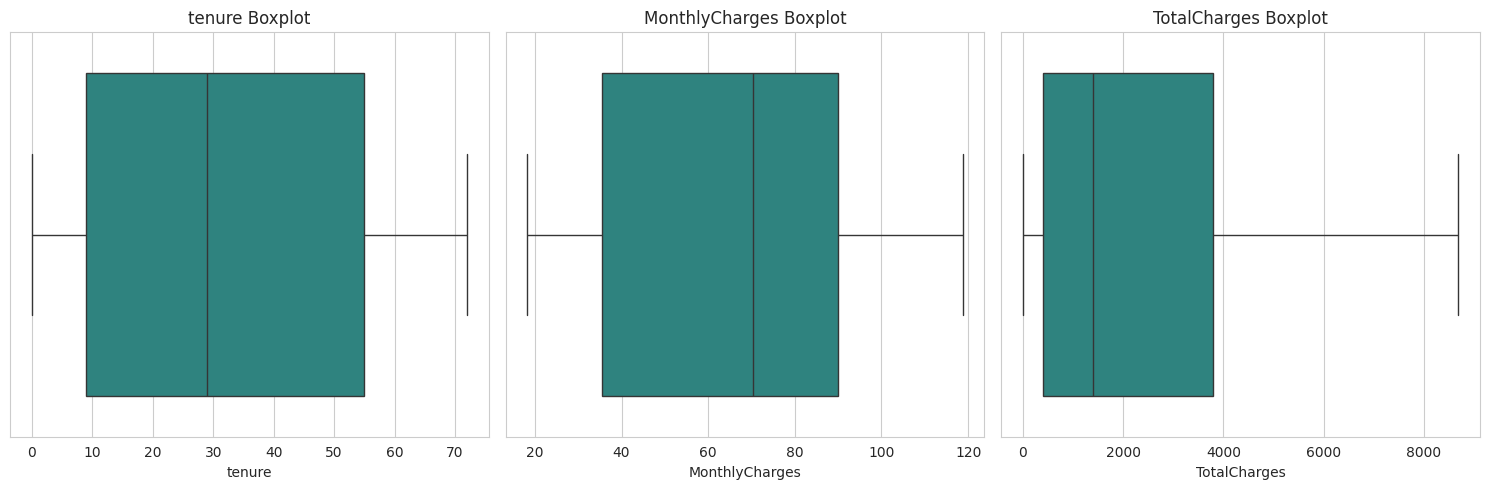

In [8]:
if file_path:
    num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

    plt.figure(figsize=(15, 5))
    for i, col in enumerate(num_cols):
        plt.subplot(1, 3, i+1)
        sns.boxplot(x=df[col], palette='viridis')
        plt.title(f'{col} Boxplot')

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/2b_outlier_detection.png")
    plt.show()

### 5. Categorical Features Analysis
Checking Contracts, Payment Methods, Internet Service, etc.

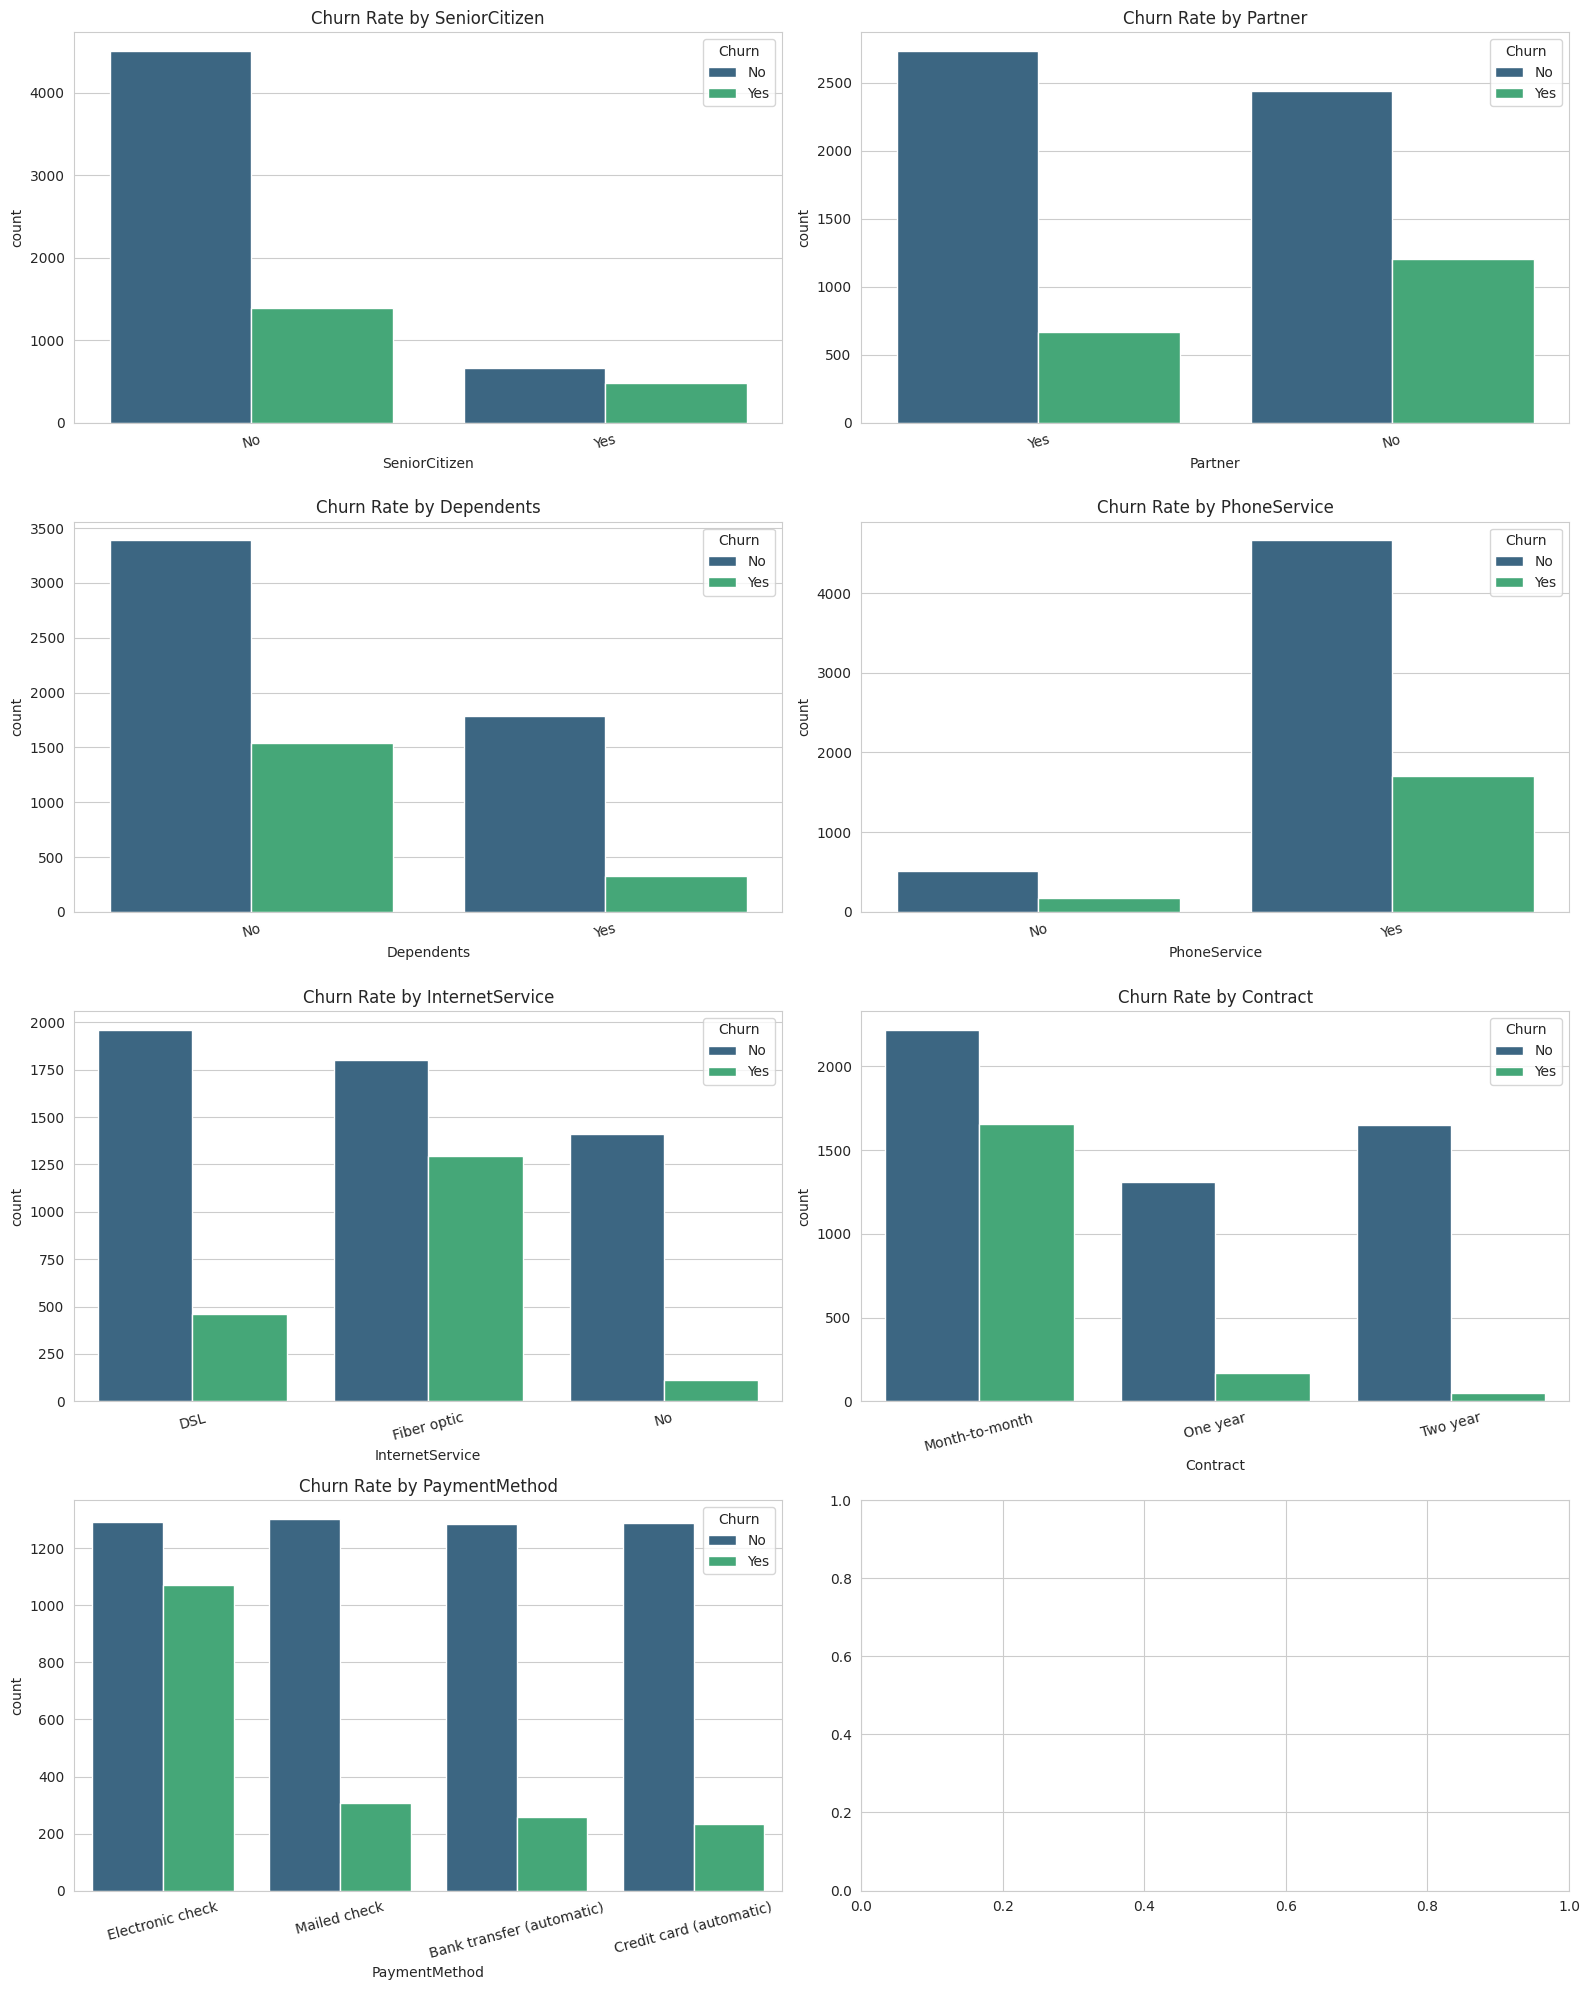

In [9]:
if file_path:
    cat_cols = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'PhoneService', 'InternetService', 'Contract', 'PaymentMethod']

    # Filter cols that actually exist
    cat_cols = [c for c in cat_cols if c in df.columns]

    fig, axes = plt.subplots(4, 2, figsize=(16, 20))
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        if i < len(axes):
            sns.countplot(data=df, x=col, hue='Churn', ax=axes[i], palette='viridis')
            axes[i].set_title(f'Churn Rate by {col}')
            axes[i].tick_params(axis='x', rotation=15)

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/3_categorical_features.png")
    plt.show()

### 6. Correlation Matrix

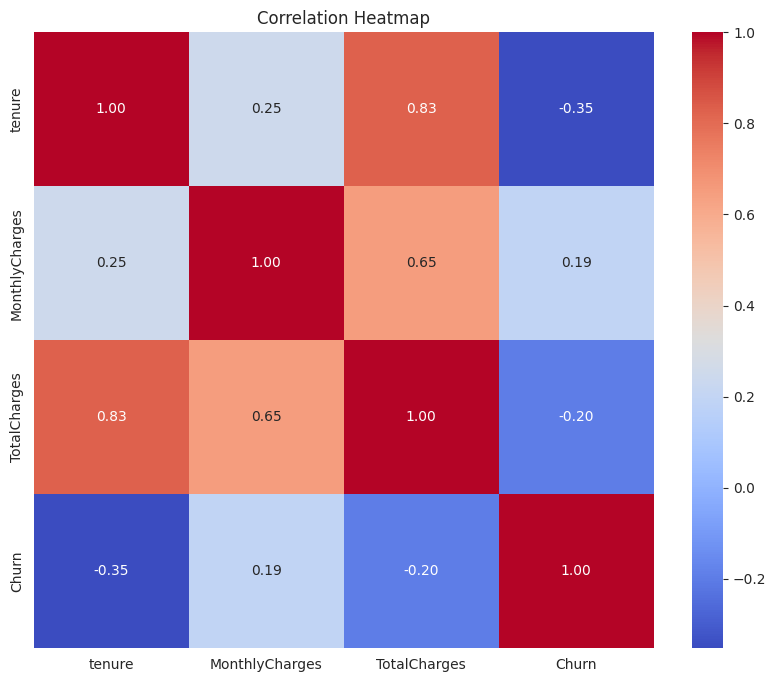

In [10]:
if file_path:
    # Convert Churn to numeric for correlation
    df_corr = df.copy()
    df_corr['Churn'] = df_corr['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Select only numeric columns
    numeric_df = df_corr.select_dtypes(include=[np.number])

    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.savefig(f"{OUTPUT_DIR}/4_correlation_heatmap.png")
    plt.show()

#**Task 02**

###1. Setup

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Scikit-Learn Modules
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, roc_curve, auc, f1_score)

# --- 1. SETUP & CONFIGURATION ---
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Create output folder
OUTPUT_DIRE = "task02_results"
os.makedirs(OUTPUT_DIRE, exist_ok=True)
print(f"Output Directory Created: {OUTPUT_DIRE}/")

Output Directory Created: task02_results/


###2. Data loading & Cleaning

In [12]:
print("\n[Step 1] Loading Dataset...")

filename = '/content/drive/MyDrive/cw/WA_Fn-UseC_-Telco-Customer-Churn.csv'
if os.path.exists(filename):
    df = pd.read_csv(filename)
    print(" -> Loaded local file.")
else:
    print("ERROR: CSV file not found! Please upload your dataset to the Colab Files tab on the left.")

# Data Cleaning
# Fix TotalCharges: It has spaces " " for new customers. Coerce creates NaNs, we fill with 0.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

# Drop customerID (irrelevant unique identifier)
if 'customerID' in df.columns:
    df = df.drop(['customerID'], axis=1)

# Encode Target: Yes -> 1, No -> 0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print(f" -> Data Shape after cleaning: {df.shape}")


[Step 1] Loading Dataset...
 -> Loaded local file.
 -> Data Shape after cleaning: (7043, 20)


###3. Preprocessing

In [13]:
print("\n[Step 2] Preprocessing & Feature Engineering...")

# One-Hot Encoding
# We use drop_first=True to avoid multicollinearity (dummy variable trap)
df_encoded = pd.get_dummies(df, drop_first=True)

# Define Features (X) and Target (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Stratified Split
# 'stratify=y' ensures the % of churners is the same in Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

# Scaling
# Neural Networks perform significantly better with scaled data (Mean=0, Std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" -> Data successfully split and scaled.")


[Step 2] Preprocessing & Feature Engineering...
 -> Data successfully split and scaled.


###4. Decision Tree

In [22]:
print("\n[Step 3] Training Decision Tree...")

# Parameter Grid
# Included 'class_weight' to handle imbalance automatically
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 10, 20],
    'class_weight': [None, 'balanced']
}

# Grid Search
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_SEED),
    dt_params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

dt_grid.fit(X_train_scaled, y_train)
best_dt = dt_grid.best_estimator_

print(f"\n -> Best Tree Params: {dt_grid.best_params_}")


[Step 3] Training Decision Tree...

 -> Best Tree Params: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}


###5. Neural Network

In [23]:
print("\n[Step 4] Training Neural Network...")
print(" -> Tuning Hyperparameters (this takes a moment)...")

# Parameter Grid
nn_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.01], # L2 regularization
    'learning_rate_init': [0.001, 0.01]
}

# MLP Classifier
mlp = MLPClassifier(max_iter=500, random_state=RANDOM_SEED)

# Grid Search
nn_grid = GridSearchCV(
    mlp,
    nn_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

nn_grid.fit(X_train_scaled, y_train)
best_nn = nn_grid.best_estimator_

print(f" -> Best Neural Net Params: {nn_grid.best_params_}")


[Step 4] Training Neural Network...
 -> Tuning Hyperparameters (this takes a moment)...
 -> Best Neural Net Params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}


###6. Generating Plots

In [24]:
print("\n[Step 5] Evaluation & Generating Plots...")

# Function to plot Confusion Matrix
def plot_cm(model, X_test, y_test, title, filename):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIRE, filename), dpi=300)
    plt.show()


[Step 5] Evaluation & Generating Plots...


###7. Evaluation


--- Decision Tree Results ---
Decision Tree Accuracy: 0.7246
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1035
           1       0.49      0.78      0.60       374

    accuracy                           0.72      1409
   macro avg       0.69      0.74      0.69      1409
weighted avg       0.79      0.72      0.74      1409



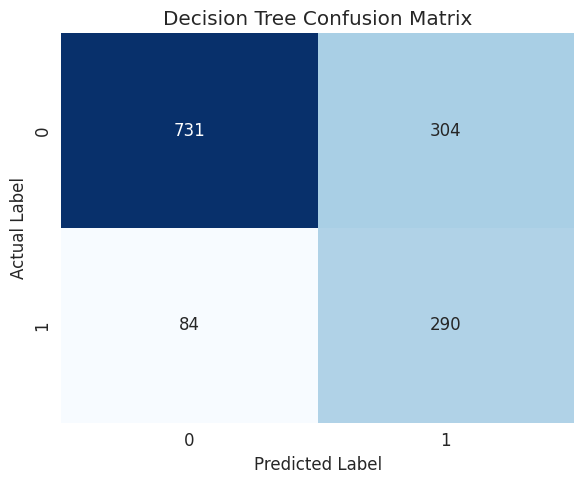


--- Neural Network Results ---
Neural Network Accuracy: 0.7814
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1035
           1       0.59      0.56      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



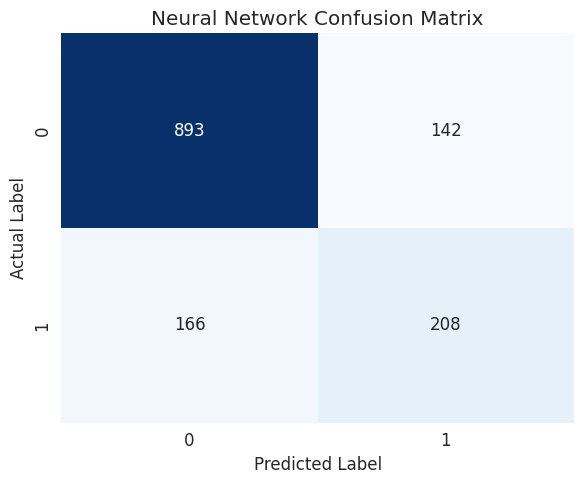

In [25]:
# 1. Decision Tree Evaluation
print("\n--- Decision Tree Results ---")
y_pred_dt = best_dt.predict(X_test_scaled)
dt_acc = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {dt_acc:.4f}")
print(classification_report(y_test, y_pred_dt))

# Plot Confusion Matrix for DT
plot_cm(best_dt, X_test_scaled, y_test, "Decision Tree Confusion Matrix", "cm_dt.png")


# 2. Neural Network Evaluation
print("\n--- Neural Network Results ---")
y_pred_nn = best_nn.predict(X_test_scaled)
nn_acc = accuracy_score(y_test, y_pred_nn)
print(f"Neural Network Accuracy: {nn_acc:.4f}")
print(classification_report(y_test, y_pred_nn))

# Plot Confusion Matrix for NN
plot_cm(best_nn, X_test_scaled, y_test, "Neural Network Confusion Matrix", "cm_nn.png")

# Task 3


--- 1. AI Ethics: Fairness & Bias Analysis ---

Analyzing Bias in: gender
   gender  Churn_Rate
0  Female    0.269209
1    Male    0.261603


/tmp/ipython-input-385728411.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group, y='Churn_Rate', data=bias_check, palette='magma')


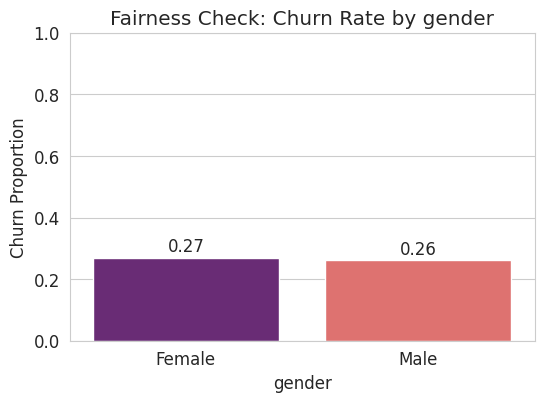

FAIRNESS CHECK PASSED: The difference is small (0.01).

Analyzing Bias in: SeniorCitizen
   SeniorCitizen  Churn_Rate
0              0    0.236062
1              1    0.416813


/tmp/ipython-input-385728411.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group, y='Churn_Rate', data=bias_check, palette='magma')


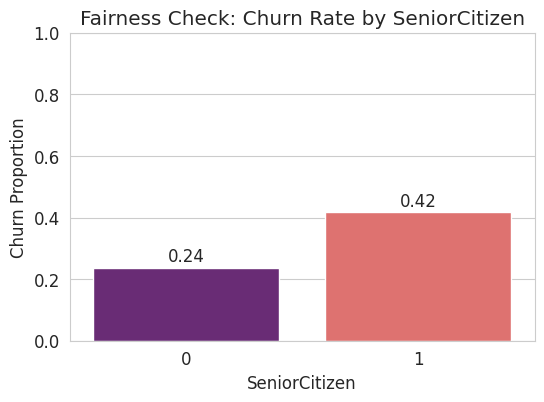

POTENTIAL BIAS DETECTED: The difference in churn predictions for SeniorCitizen is large (0.18).
Strategy: We must ensure the model isn't using this feature to discriminate unlawfully.

--- 2. Post-Deployment: Data Drift Monitoring ---
Simulating next month's data to check if model needs retraining...


/tmp/ipython-input-385728411.py:75: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(current_data, shade=True, label='Training Data (Baseline)', color='blue')
/tmp/ipython-input-385728411.py:76: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(new_data, shade=True, label='New Data (Live)', color='red')


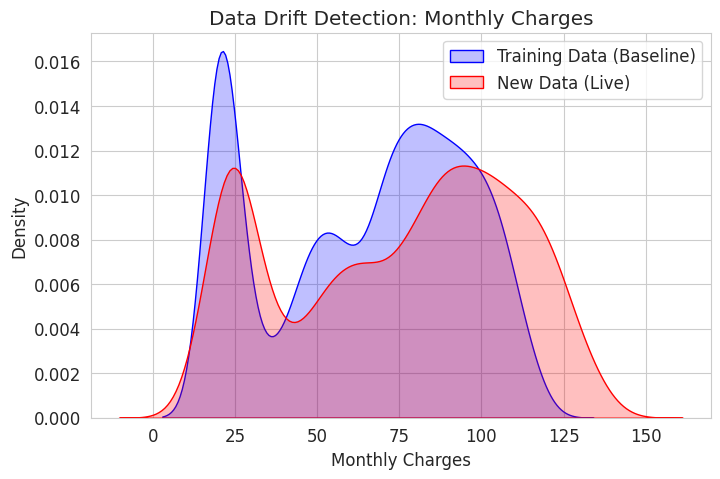

Drift Test (KS-Test) P-Value: 0.00000
DATA DRIFT DETECTED!
Strategy: The data distribution has changed significantly.
Action: Trigger automatic retraining pipeline.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# --- CONFIGURATION ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

def load_data():
    # Re-load data to ensure we have the raw columns for Ethics check
    filename = '/content/drive/MyDrive/cw/WA_Fn-UseC_-Telco-Customer-Churn.csv'
    df = pd.read_csv(filename)

    # Basic cleanup
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    return df

# ==========================================
# PART 1: AI ETHICS (Bias Detection)
# ==========================================
def check_fairness(df):
    print("\n--- 1. AI Ethics: Fairness & Bias Analysis ---")

    # We check if the Churn Rate is significantly different for protected groups
    protected_groups = ['gender', 'SeniorCitizen']

    for group in protected_groups:
        print(f"\nAnalyzing Bias in: {group}")

        # Calculate Churn Rate per group
        bias_check = df.groupby(group)['Churn'].mean().reset_index()
        bias_check.columns = [group, 'Churn_Rate']

        print(bias_check)

        # Visualization
        plt.figure(figsize=(6, 4))
        sns.barplot(x=group, y='Churn_Rate', data=bias_check, palette='magma')
        plt.title(f'Fairness Check: Churn Rate by {group}')
        plt.ylabel('Churn Proportion')
        plt.ylim(0, 1)

        # Add values
        for index, row in bias_check.iterrows():
            plt.text(index, row.Churn_Rate + 0.02, f'{row.Churn_Rate:.2f}', ha='center')

        plt.show()

        # Ethics Interpretation
        rates = bias_check['Churn_Rate'].values
        diff = abs(rates[0] - rates[1])
        if diff > 0.1:
            print(f"POTENTIAL BIAS DETECTED: The difference in churn predictions for {group} is large ({diff:.2f}).")
            print("Strategy: We must ensure the model isn't using this feature to discriminate unlawfully.")
        else:
            print(f"FAIRNESS CHECK PASSED: The difference is small ({diff:.2f}).")

# ==========================================
# PART 2: POST-DEPLOYMENT STRATEGY (Drift)
# ==========================================
def simulate_deployment_monitoring(df):
    print("\n--- 2. Post-Deployment: Data Drift Monitoring ---")
    print("Simulating next month's data to check if model needs retraining...")

    # Simulate "New Data" (e.g., Next month, customers are slightly different)
    # We artificially increase MonthlyCharges to simulate inflation/price hikes
    current_data = df['MonthlyCharges']
    new_data = df['MonthlyCharges'] * 1.15 + np.random.normal(0, 5, len(df))

    # Visualization of Drift
    plt.figure(figsize=(8, 5))
    sns.kdeplot(current_data, shade=True, label='Training Data (Baseline)', color='blue')
    sns.kdeplot(new_data, shade=True, label='New Data (Live)', color='red')
    plt.title('Data Drift Detection: Monthly Charges')
    plt.xlabel('Monthly Charges')
    plt.legend()
    plt.show()

    # Statistical Test (Kolmogorov-Smirnov Test)
    stat, p_value = ks_2samp(current_data, new_data)
    print(f"Drift Test (KS-Test) P-Value: {p_value:.5f}")

    if p_value < 0.05:
        print("DATA DRIFT DETECTED!")
        print("Strategy: The data distribution has changed significantly.")
        print("Action: Trigger automatic retraining pipeline.")
    else:
        print("No Drift Detected. Model is stable.")

# --- EXECUTION ---
if __name__ == "__main__":
    df = load_data()
    check_fairness(df)
    simulate_deployment_monitoring(df)